## 1. Overview 

The goal is to implement https://raytracing.github.io/books/RayTracingInOneWeekend.html using Python and numpy.

I am going to follow the book and number chapters in the same way, but plan to refactor the code in two main areas:
* take advantage of python libraries where possible, e.g. encoding the output image
* vectorize the code: instead of looping over each image pixel, we will declare a big numpy array and call a single function that will work across the whole array. Otherwise, the function call overhead would be enormous.



## 2. Output an image

Rather than writing PPM files in ASCII, we are going to leverage the Python Image Library (PIL). PIL can take as an input a [rows,cols,3] array, which is exactly what we need. To vectorize the color computation, we are going to use one of the numpy "index tricks", *mgrid*. mgrid will give us two rectangular arrays with respectively the x and y coordinate of each pixel, for example:

In [3]:
import numpy as np

x, y = np.mgrid[0:4,0:4]
print(x)
print(y)

[[0 0 0 0]
 [1 1 1 1]
 [2 2 2 2]
 [3 3 3 3]]
[[0 1 2 3]
 [0 1 2 3]
 [0 1 2 3]
 [0 1 2 3]]


We will also convert the indexes to floating point. The image is pre-allocated in order to allow numpy to work on big arrays, and instead of looping over each element, we use numpy to calculate all pixel values in one go.

Notice how the grid and the image are height,width instead of the opposite. This is because numpy works in rows,columns order, and the number of rows corresponds to the image height.

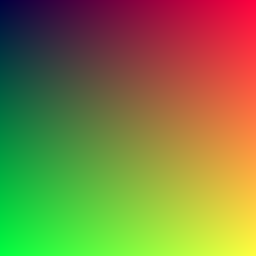

In [4]:
from PIL import Image

# Image
width = 256
height = 256

ii, jj = np.mgrid[:float(height), :float(width)]

img = np.zeros((height, width, 3), dtype='uint8')

r = jj/(width-1)
g = ii/(height-1)
b = 0.25

img[:,:,0] = 255.299*r
img[:,:,1] = 255.299*g
img[:,:,2] = 255.299*b

image = Image.fromarray(img)
image.save('img.bmp')
display(image)

## 3. The vec3 class

We need a basic vec3 type like the one in the C++ book. Following Python traditions, class members are not encaspsulated with getters/setters (if needed, you can always turn them into properties later, without breaking backward compatibility). We also add a few useful methods, that will allow us to use the Vec3 almost as if it was a regular numpy array.


In [9]:
class Vec3:
    def __init__(self, x=0.0, y=0.0, z=0.0):
        self.x = np.array(x, dtype=np.float32)
        self.y = np.array(y, dtype=np.float32)
        self.z = np.array(z, dtype=np.float32)

    @staticmethod
    def empty(size):
        x = np.empty(size, dtype=np.float32)
        y = np.empty(size, dtype=np.float32)
        z = np.empty(size, dtype=np.float32)
        return Vec3(x,y,z)

    @staticmethod
    def zeros(size):
        x = np.zeros(size, dtype=np.float32)
        y = np.zeros(size, dtype=np.float32)
        z = np.zeros(size, dtype=np.float32)
        return Vec3(x,y,z)

    @staticmethod
    def ones(size):
        x = np.ones(size, dtype=np.float32)
        y = np.ones(size, dtype=np.float32)
        z = np.ones(size, dtype=np.float32)
        return Vec3(x,y,z)
    
    @staticmethod
    def where(condition, v1, v2):
        x = np.where(condition, v1.x, v2.x)
        y = np.where(condition, v1.y, v2.y)
        z = np.where(condition, v1.z, v2.z)
        return Vec3(x,y,z)
    
    def clip(self, vmin, vmax):
        x = np.clip(self.x, vmin, vmax)
        y = np.clip(self.y, vmin, vmax)
        z = np.clip(self.z, vmin, vmax)
        return Vec3(x,y,z)

    def fill(self, value):
        self.x.fill(value)
        self.y.fill(value)
        self.z.fill(value)

    def repeat(self, n):
        x = np.repeat(self.x, n)
        y = np.repeat(self.y, n)
        z = np.repeat(self.z, n)
        return Vec3(x,y,z)
    
    def __str__(self):
        return 'vec3: x:%s y:%s z:%s' % (str(self.x), str(self.y), str(self.z))
    
    def __len__(self):
        return self.x.size

    def __add__(self, other):
        return Vec3(self.x + other.x, self.y + other.y, self.z + other.z)

    def __sub__(self, other):
        return Vec3(self.x - other.x, self.y - other.y, self.z - other.z)

    def __neg__(self):
        return Vec3(-self.x, -self.y, -self.z)

    def __mul__(self, scalar):
        return Vec3(self.x*scalar, self.y*scalar, self.z*scalar)

    def multiply(self, other):
        return Vec3(self.x * other.x, self.y * other.y, self.z * other.z)

    def __truediv__(self, scalar):
        return Vec3(self.x/scalar, self.y/scalar, self.z/scalar)
    
    def tile(self, shape):
        '''Replicate np.tile on each component'''
        return Vec3(np.tile(self.x, shape), np.tile(self.y, shape), np.tile(self.z, shape))

    def __getitem__(self, idx):
        '''Extract a vector subset'''
        return Vec3(self.x[idx], self.y[idx], self.z[idx])
    
    def __setitem__(self, idx, other):
        '''Set a vector subset from another vector'''
        self.x[idx] = other.x
        self.y[idx] = other.y
        self.z[idx] = other.z

    def join(self):
        '''Join the three components into a single 3xN array'''
        return np.vstack((self.x, self.y, self.z))
    
    def append(self, other):
        '''Append another vector to this one.
        Use concatenate() because cupy has no append function.
        '''
        self.x = np.concatenate((self.x, other.x))
        self.y = np.concatenate((self.y, other.y))
        self.z = np.concatenate((self.z, other.z))
        

## Aliases
Point3 = Vec3
Color = Vec3

## Utility functions
def unit_vector(v):
    return v / length(v)

def dot(a, b):
    return a.x*b.x + a.y*b.y + a.z*b.z

def length(v):
    return length_squared(v)**0.5

def length_squared(v):
    return v.x*v.x + v.y*v.y + v.z*v.z

def cross(a, b):
    return Vec3(a.y*b.z - a.z*b.y,
                -(a.x*b.z - a.z*b.x),
                a.x*b.y - a.y*b.x)

Let's also write a quick function that can take a Vec3 object and return an Image object. Our arrays are 3xN, while the Image.fromarray() method expects Nx3, so we need to swap the axes. The function is able to take 1d or 2d arrays as an input. It will assume that 1d arrays are grayscale images, and 2d arrays are composition of 3 grayscale images in RGB order.

In [10]:
def convert_to_pil(v, width, height, scale = 255.999):
    
    img = (v.join() * scale).astype(np.uint8)

    if len(img.shape) == 2:
        img_rgb = img.swapaxes(0,1).reshape(height, width, 3)
    else:
        img_rgb = img.reshape(height, width)

    return Image.fromarray(img_rgb)
    

## 4. Rays, a Simple Camera, and Background
### 4.1 The ray class

A direct translation of the C++ one. We add some useful methods to get/set a ray subset and get the number of rays.

In [11]:
class Ray:
    def __init__(self, origin, direction):
        self.origin = origin
        self.direction = direction

    def at(self, t):
        return self.origin + self.direction*t
    
    def __getitem__(self, idx):
        return Ray(self.origin[idx], self.direction[idx])

    def __setitem__(self, idx, other):
        self.origin[idx] = other.origin
        self.direction[idx] = other.direction
    
    def __len__(self):
        return self.origin.x.size
  

### 4.2 Sending Rays Into the Scene

Here is our version of the ray_color function.

In [12]:
def ray_color(rays):
    unit_direction = unit_vector(rays.direction)
    t = 0.5 * unit_direction.y + 1.0
    return Color(1.0, 1.0, 1.0)*(1-t) + Color(0.5, 0.7, 1.0)*t



The new image and camera defintion code is basically the same as in C++. We are going to reverse the vertical direction sign, because the Python image displays put the zero at the bottom:

In [13]:
aspect_ratio = 16.0 / 9.0
width = 400
height = int(width / aspect_ratio)
print('Image size: %dx%d' % (width, height))

viewport_height = 2.0
viewport_width = aspect_ratio * viewport_height;
focal_length = 1.0;

origin = Point3(0, 0, 0);
horizontal = Vec3(viewport_width, 0, 0);
vertical = Vec3(0, -viewport_height, 0);
lower_left_corner = origin - horizontal/2 - vertical/2 - Vec3(0, 0, focal_length);



Image size: 400x225


The image code needs to be significantly revised: u and v are calculated directly from the image coordinates, and flattened to a vector. There is no need to allocate the output image, since it is the output of the ray color calculation.

Also note how u and v are enplicitly converted to 32-bit floats. This is necessary because the *float* cast in the mgrid call uses Python floats, which are usually double precision.

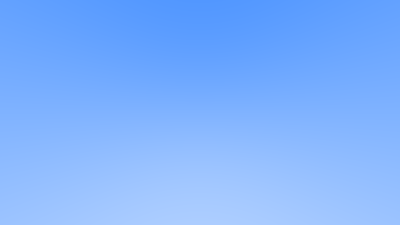

In [14]:
ii, jj = np.mgrid[:float(height), :float(width)]

u = (jj/(width-1)).flatten().astype(np.float32)
v = (ii/(height-1)).flatten().astype(np.float32)

all_origins = origin.tile((u.size,))
r = Ray(all_origins, lower_left_corner
                     + horizontal * u
                     + vertical * v
                     - all_origins)

img = ray_color(r)

display(convert_to_pil(img, width, height, scale = 255.299))

## 5 Adding a Sphere

### 5.2 Creating our first Raytraced image

The sphere code is the same as in C++.

We modify the ray_color() function to force the red color wherever the sphere has been hit. Instead of using an *if* instruction ray-by-ray as in C++, we use *np.where* to set all rays in one go.

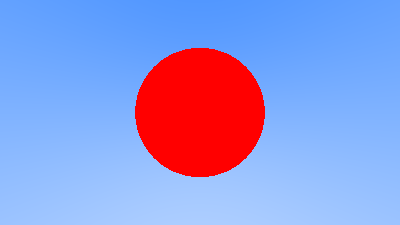

In [15]:
def hit_sphere(center, radius, rays):
    oc = rays.origin - center
    a = dot(rays.direction, rays.direction)
    b = 2.0 * dot(oc, rays.direction)
    c = dot(oc, oc) - radius*radius
    discriminant = b*b - 4*a*c
    return discriminant > 0

def ray_color(rays):

    unit_direction = unit_vector(rays.direction)
    t = 0.5 * unit_direction.y + 1.0
    gradient = Color(1.0, 1.0, 1.0)*(1-t) + Color(0.5, 0.7, 1.0)*t

    sphere = hit_sphere(Point3(0,0,-1), 0.5, rays)
    gradient[np.where(sphere)] = Color(1, 0, 0)
    return gradient

img = ray_color(r)
display(convert_to_pil(img, width, height, scale = 255.299))

## 6. Surface Normals and Multiple Objects
### 6.1 Shading with Surface Normals

The *if* instruction in the new C++ *hit_sphere* function is replaced by *np.where()*.
Execution of this cell may result in a RuntimeWarning, because we are calling sqrt() on the whole frame, including where the discriminant is negative.

/home/puglisi/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in sqrt
  import sys


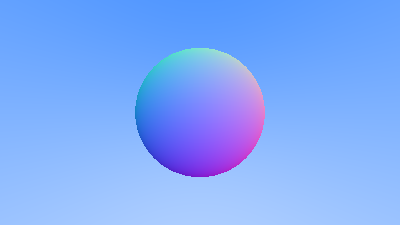

In [16]:
def hit_sphere(center, radius, rays):
    oc = rays.origin - center
    a = dot(rays.direction, rays.direction)
    b = 2.0 * dot(oc, rays.direction)
    c = dot(oc, oc) - radius*radius
    discriminant = b*b - 4*a*c
    root = (-b - np.sqrt(discriminant) ) / (2.0*a)
    return np.where(discriminant > 0, root, -1.0)

def ray_color(rays):

    unit_direction = unit_vector(rays.direction)
    t = 0.5 * unit_direction.y + 1.0
    gradient = Color(1.0, 1.0, 1.0)*(1-t) + Color(0.5, 0.7, 1.0)*t

    t = hit_sphere(Point3(0,0,-1), 0.5, rays)
    N = unit_vector(rays.at(t) - Vec3(0, 0, -1))
    c = Color(N.x + 1, N.y + 1, N.z + 1)

    hit_rays = np.where(t > 0)
    gradient[hit_rays] = c[hit_rays] * 0.5
    return gradient

# Replicate here the relevant part of the main code (just for display)
img = ray_color(r)
display(convert_to_pil(img, width, height, scale = 255.299))


We are going to remove further warnings regarding NaNs and negative sqrt values with this setting:

In [17]:
np.seterr(invalid='ignore')   # Returns the old settings

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

### 6.2 Simplifying the Ray-Sphere Intersection Code

The simplification is straightforward to replicate:

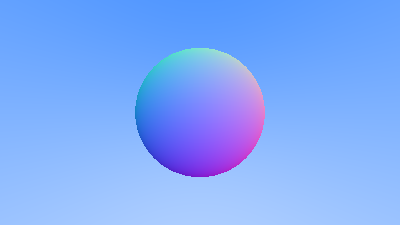

In [18]:
def hit_sphere(center, radius, rays):
    oc = rays.origin - center
    a = length_squared(rays.direction)
    half_b = dot(oc, rays.direction)
    c = length_squared(oc) - radius*radius
    discriminant = half_b*half_b - a*c
    root = (-half_b - np.sqrt(discriminant) ) / a
    return np.where(discriminant > 0, root, -1.0)


# Replicate here the relevant part of the main code (just for display)

img = ray_color(r)
display(convert_to_pil(img, width, height, scale = 255.299))


## Intermezzo: benchmarking

It's time to see if our efforts to keep things vectorized work. Since the original image was quite small, lets make it bigger (2000 pixels width) for benchmarking purposes, otherwise the code will finish in a few milliseconds.

In [20]:
# Context manager for cuda device synchronization

import time
class Timer:

    def __enter__(self):
        self.t0 = time.time()

    def __exit__(self, *args):
        t1 = time.time()
        print('Elapsed time: %.3f s' % (t1 - self.t0))
    
def render_image(width, height):

    with Timer():
        ii, jj = np.mgrid[:float(height), :float(width)]

        u = (jj/(width-1)).flatten().astype(np.float32)
        v = (ii/(height-1)).flatten().astype(np.float32)

        all_origins = origin.tile((u.size,))
        r = Ray(all_origins, lower_left_corner
                             + horizontal * u
                             + vertical * v
                             - all_origins)

        img = ray_color(r)
        
    return img

def render(width, height):
    colors = render_image(width, height)
    image = convert_to_pil(colors, width, height)
    return image

def benchmark(benchmark_width = 2000):
    benchmark_height = int(benchmark_width / aspect_ratio)
    print('Image size: %dx%d' % (benchmark_width, benchmark_height))

    for n in range(4):
        image = render(benchmark_width, benchmark_height)
    image.save('img.bmp')

benchmark()

Image size: 2000x1125
Elapsed time: 0.515 s
Elapsed time: 0.420 s
Elapsed time: 0.572 s
Elapsed time: 0.471 s


### 6.3 An Abstraction for Hittable Objects

The gist of the code: hit all rays on all spheres and, for each ray, remember the closest hit. Instead of looping over rays and then on all hittable objects for each ray, we are going to loop over hittable objects and, for each object, do all the rays in one go. For any hit, we check whether we are the closest hit and update a hit_record that is kept between calls.


In [21]:
from collections import namedtuple
from abc import abstractmethod

class HitRecord:
    def __init__(self, size):
        self.p = Vec3.empty(size)
        self.normal = Vec3.empty(size)
        self.t = np.full(size, np.inf, dtype=np.float32)
        self.front_face = np.zeros(size, dtype=np.float32)
        
                           
class Hittable:
    @abstractmethod
    def update_hit_record(rays, t_min, t_max, hit_record: HitRecord):
        pass

    
class Sphere(Hittable):

    def __init__(self, center, radius):
        self.center = center
        self.radius = radius

    def update_hit_record(self, rays, t_min, t_max, hit_record):

        oc = rays.origin - self.center
        a = length_squared(rays.direction)
        half_b = dot(oc, rays.direction)
        c = length_squared(oc) - self.radius*self.radius
        discriminant = half_b*half_b - a*c
        
        root = np.sqrt(discriminant)
        t1 = (-half_b - root) / a
        t2 = (-half_b + root) / a
        hit1 = np.logical_and(t1 < t_max, t1 > t_min)
        hit2 = np.logical_and(t2 < t_max, t2 > t_min)
        
        # Combine the two hits, precedence to t1 (closest)
        t = np.where(hit2, t2, np.inf)
        t = np.where(hit1, t1, t)       
        
        # Detect where in the rays list we are the closest hit
        closest = np.where(t < hit_record.t)
        
        # Calculate normal
        hit_rays = rays[closest]
        
        p = hit_rays.at(t[closest])
        outward_normal = (p - self.center) / self.radius 
        front_face = dot(hit_rays.direction, outward_normal) < 0 
        normal = Vec3.where(front_face, outward_normal, -outward_normal)
        
        # Update hit records
        hit_record.p[closest] = p
        hit_record.normal[closest] = normal
        hit_record.t[closest] = t[closest]
        hit_record.front_face[closest] = front_face
        

There is not really a need for the hittable_list type. Rather, we can just loop over the world in three lines. Whenever we didn't hit anything in the world, *hit_record.t* will be infinite, and we put the gradient there.

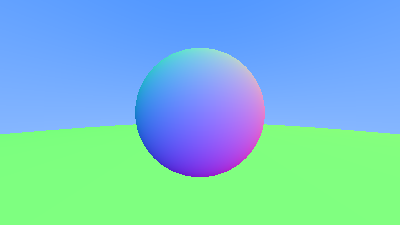

In [24]:
world = [
    Sphere(Point3(0,0,-1), 0.5),
    Sphere(Point3(0,-100.5,-1), 100),
]

def ray_color(rays):

    unit_direction = unit_vector(rays.direction)
    t = 0.5 * unit_direction.y + 1.0
    gradient = Color(1.0, 1.0, 1.0)*(1-t) + Color(0.5, 0.7, 1.0)*t

    hit_record = HitRecord(len(rays))
    for hittable in world:
        hittable.update_hit_record(rays, 0, np.inf, hit_record)

    hits = np.where(hit_record.t != np.inf)
    hit_color = (hit_record.normal[hits] + Vec3(1,1,1)) * 0.5
    gradient[hits] = hit_color
    return gradient

img = ray_color(r)
display(convert_to_pil(img, width, height))

### Intermezzo: new benchmark
A bit slowe but not by much

In [23]:
benchmark()

Image size: 2000x1125
Elapsed time: 0.620 s
Elapsed time: 0.583 s
Elapsed time: 0.585 s
Elapsed time: 0.578 s


## 7. Antialiasing
### 7.1 Some Random Number Utilities


In [26]:
np.random.uniform(low=0.0, high=1.0, size=5)

array([0.08109907, 0.80729955, 0.05157412, 0.93444416, 0.77747695])

We will wrap the to have a cast to float 32bits:

In [30]:
def my_random(low, high, size):
    return np.random.uniform(low, high, size).astype(np.float32)



### 7.2 Generating Pixels with Multiple Samples

The camera class just wraps the previous code into a class definition. We will also add a small *get_camera()* function, that will be useful later on when we will change the camera

In [31]:
class Camera:

    def __init__(self):
        aspect_ratio = 16.0 / 9.0;
        viewport_height = 2.0;
        viewport_width = aspect_ratio * viewport_height;
        focal_length = 1.0;

        self.origin = Point3(0, 0, 0);
        self.horizontal = Vec3(viewport_width, 0.0, 0.0);
        self.vertical = Vec3(0.0, -viewport_height, 0.0);
        self.lower_left_corner = (self.origin
                                  - self.horizontal/2
                                  - self.vertical/2
                                  - Vec3(0, 0, focal_length))

    def get_ray(self, u, v):
        all_origins = origin.tile((u.size,))
        return Ray(all_origins, self.lower_left_corner
                                + self.horizontal * u
                                + self.vertical * v
                                - all_origins)


def get_camera():
    return Camera()


We add the samples per pixels as in the C++ code:

In [32]:
aspect_ratio = 16.0 / 9.0
width = 400
height = int(width / aspect_ratio)
samples_per_pixel = 10    # Use just 10 values otherwise the notebook gets too slow


And modify the render_image function to add the random distribution, add the generated images together and clip the output as in the C++ code. 

Elapsed time: 0.249 s


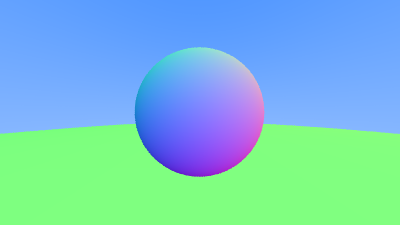

In [33]:
def render_image(width, height):
    with Timer():
        ii, jj = np.mgrid[:float(height), :float(width)]

        u = (jj/(width-1)).flatten().astype(np.float32)
        v = (ii/(height-1)).flatten().astype(np.float32)

        cam = get_camera()

        img = Vec3.zeros(width * height)
        for s in range(samples_per_pixel):

            uu = u + my_random(0.0, 1.0, u.size) / (width - 1)
            vv = v + my_random(0.0, 1.0, v.size) / (height - 1)

            r = cam.get_ray(uu,vv)

            img += ray_color(r)

        img *= 1.0 / samples_per_pixel
        return img.clip(0.0, 0.999)


display(render(width, height))


## 8. Diffuse Materials
### 8.1 A Simple Diffuse Material

The C++ code uses recursion, which makes sense since it is working on single rays that are bouncing around. We are instead working with numpy arrays, so I have refactored the code into an interation based on depth.

At each iteration, the number of rays bouncing around is reduced, and so is the hit record table. The *HitRecord.index* array keeps track of where in the image the rays where originally going, so we can use their last bounce to generate the image.

This requires a major refactor of the ray_color() function.

Elapsed time: 0.980 s


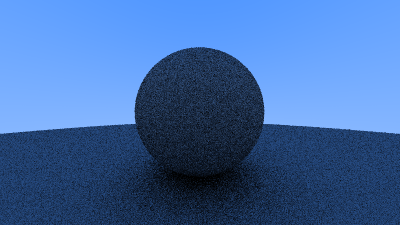

In [35]:
aspect_ratio = 16.0 / 9.0
width = 400
height = int(width / aspect_ratio)
samples_per_pixel = 10    # Use just 10 values otherwise the notebook gets too slow
max_depth = 50


class HitRecord:
    def __init__(self, n, empty=False):
        self.p           = empty or Vec3.empty(n)
        self.normal      = empty or Vec3.empty(n)
        self.t           = empty or np.full(n, np.inf, dtype=np.float32)
        self.front_face  = empty or np.zeros(n, dtype=np.float32)
        self.index       = empty or np.arange(n, dtype=np.int32)

    def __getitem__(self, idx):
        other = HitRecord(len(idx), empty=True)
        other.p          = self.p[idx]
        other.normal     = self.normal[idx]
        other.t          = self.t[idx]
        other.front_face = self.front_face[idx]
        other.index      = self.index[idx]
        return other
    
    
def random_in_unit_sphere(n):
    '''Generate random Vec3 arrays in batches and keep the ones inside the unit sphere'''

    values = Vec3.zeros(0)

    while len(values) < n:
        random_values = Vec3(my_random(-1.0, 1.0, n), my_random(-1.0, 1.0, n), my_random(-1.0, 1.0, n))
        good_ones = length_squared(random_values) < 1
        values.append(random_values[good_ones])
        
    return values[np.arange(n)]


def ray_color(rays):
    '''Iterative version of ray_color'''

    frame_intensity = np.full(len(rays), 1.0, dtype=np.float32)
    frame_rays = rays
    hit_record = HitRecord(len(rays))

    for d in range(max_depth):

        # Initialize all distances to infinite
        hit_record.t.fill(np.inf)
        for hittable in world:
            hittable.update_hit_record(rays, 0, np.inf, hit_record)

        # Rays that have hit something will be used in the next iteration
        hit_idx = np.where(hit_record.t != np.inf)[0]

        if len(hit_idx) > 0:

            # Narrow down the hit record and calculate new rays
            hit_record = hit_record[hit_idx]
            
            target = (hit_record.p
                      + hit_record.normal
                      + random_in_unit_sphere(len(hit_idx)))

            rays = Ray(hit_record.p, target - hit_record.p)

            # Update global arrays
            frame_rays.direction[hit_record.index] = rays.direction
            frame_intensity[hit_record.index] *= 0.5 

        else:
            break

    unit_direction = unit_vector(frame_rays.direction)
    t = 0.5 * unit_direction.y + 1.0
    img = (Color(1.0, 1.0, 1.0) * (1 - t) + Color(0.5, 0.7, 1.0) * t) * frame_intensity

    return img


display(render(width, height))


### 8.3 Using Gamma Correction for Accurate Color Intensity


Gamma correction goes into our get_image() function.

Elapsed time: 1.004 s


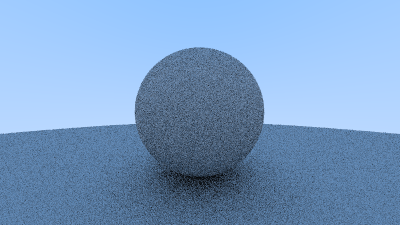

In [36]:


def render_image(width, height):
    with Timer():
        ii, jj = np.mgrid[:float(height), :float(width)]

        u = (jj/(width-1)).flatten().astype(np.float32)
        v = (ii/(height-1)).flatten().astype(np.float32)

        cam = get_camera()

        img = Vec3.zeros(width * height)
        for s in range(samples_per_pixel):

            uu = u + my_random(0.0, 1.0, u.size) / (width - 1)
            vv = v + my_random(0.0, 1.0, v.size) / (height - 1)

            r = cam.get_ray(uu,vv)

            img += ray_color(r)

        img *=  1.0 / samples_per_pixel
        img.x = np.sqrt(img.x)
        img.y = np.sqrt(img.y)
        img.z = np.sqrt(img.z)
        img = img.clip(0.0, 0.999)

    return img


display(render(width, height))


### 8.4 Fixing shadow acne
We change the t_min  from 0 to 0.001

Elapsed time: 0.718 s


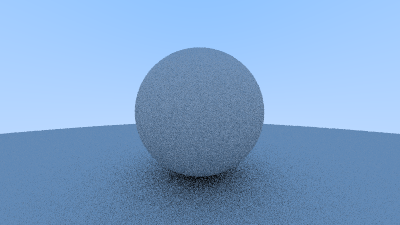

In [37]:

def ray_color(rays):
    '''Iterative version of ray_color'''

    frame_intensity = np.full(len(rays), 1.0, dtype=np.float32)
    frame_rays = rays
    hit_record = HitRecord(len(rays))

    for d in range(max_depth):

        # Initialize all distances to infinite and propagate all rays
        hit_record.t.fill(np.inf)
        for hittable in world:
            hittable.update_hit_record(rays, 0.001, np.inf, hit_record)   # Changed here

        # Rays that have hit something will be used in the next iteration
        hit_idx = np.where(hit_record.t != np.inf)[0]

        if len(hit_idx) > 0:

            # Narrow down the hit record and calculate new rays
            hit_record = hit_record[hit_idx]
            
            target = (hit_record.p
                      + hit_record.normal
                      + random_in_unit_sphere(len(hit_idx)))

            rays = Ray(hit_record.p, target - hit_record.p)

            # Update global arrays
            frame_rays.direction[hit_record.index] = rays.direction
            frame_intensity[hit_record.index] *= 0.5 

        else:
            break

    unit_direction = unit_vector(frame_rays.direction)
    t = 0.5 * unit_direction.y + 1.0
    img = (Color(1.0, 1.0, 1.0) * (1 - t) + Color(0.5, 0.7, 1.0) * t) * frame_intensity

    return img

display(render(width, height))



### 8.5 True Lambertian Reflection
We follow the C++ code, changing the random_unit_vector() function to generate N arrays in one call:

Elapsed time: 0.591 s


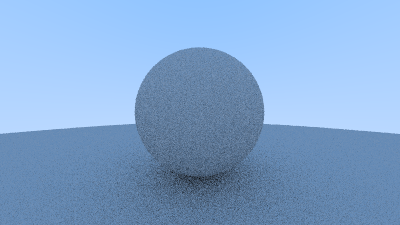

In [38]:

def random_unit_vectors(n):
    a = my_random(0.0, 2.0*np.pi, n)
    z = my_random(-1.0, 1.0, n)
    r = np.sqrt(1 - z*z)
    return Vec3(r*np.cos(a), r*np.sin(a), z)

def ray_color(rays):
    '''Iterative version of ray_color'''

    frame_intensity = np.full(len(rays), 1.0, dtype=np.float32)
    frame_rays = rays
    hit_record = HitRecord(len(rays))

    for d in range(max_depth):

        # Initialize all distances to infinite and propagate all rays
        hit_record.t.fill(np.inf)
        for hittable in world:
            hittable.update_hit_record(rays, 0.001, np.inf, hit_record) 

        # Rays that have hit something will be used in the next iteration
        hit_idx = np.where(hit_record.t != np.inf)[0]

        if len(hit_idx) > 0:

            # Narrow down the hit record and calculate new rays
            hit_record = hit_record[hit_idx]
            
            target = (hit_record.p
                      + hit_record.normal
                      + random_unit_vectors(len(hit_idx)))     # Changed here

            rays = Ray(hit_record.p, target - hit_record.p)

            # Update global arrays
            frame_rays.direction[hit_record.index] = rays.direction
            frame_intensity[hit_record.index] *= 0.5 

        else:
            break

    unit_direction = unit_vector(frame_rays.direction)
    t = 0.5 * unit_direction.y + 1.0
    img = (Color(1.0, 1.0, 1.0) * (1 - t) + Color(0.5, 0.7, 1.0) * t) * frame_intensity

    return img


display(render(width, height))


## 9 Metal
### 9.2 A Data Structure to Describe Ray-Object Intersections

We now have a Material abstract class and a material field in the HitRecord, updated by the Sphere field whenever there is a hit. We add just two lines to the Sphere class.


In [39]:
import numpy as np

ScatterResult = namedtuple('ScatterResult', 'attenuation rays is_scattered')

class Material:
    def scatter(r_in: Ray, ray_idx, rec: HitRecord) -> ScatterResult:
        pass

class HitRecord:
    def __init__(self, n, empty=False):
        self.p           = empty or Vec3.empty(n)
        self.normal      = empty or Vec3.empty(n)
        self.t           = empty or np.full(n, np.inf, dtype=np.float32)
        self.front_face  = empty or np.zeros(n, dtype=np.float32)
        self.index       = empty or np.arange(n, dtype=np.int32)
        self.material_id = empty or np.zeros(n, dtype=np.int64)

    def __getitem__(self, idx):
        other = HitRecord(len(idx), empty=True)
        other.p           = self.p[idx]
        other.normal      = self.normal[idx]
        other.t           = self.t[idx]
        other.front_face  = self.front_face[idx]
        other.index       = self.index[idx]
        other.material_id = self.material_id[idx]
        return other


class Sphere(Hittable):
    '''A hittable sphere that knows how to update the hit record'''

    def __init__(self, center, radius, material):
        self.center = center
        self.radius = radius
        self.material = material                 # Changed here

    def update_hit_record(self, rays, t_min, t_max, hit_record):

        oc = rays.origin - self.center
        a = length_squared(rays.direction)
        half_b = dot(oc, rays.direction)
        c = length_squared(oc) - self.radius*self.radius
        discriminant = half_b*half_b - a*c
        
        root = np.sqrt(discriminant)
        t1 = (-half_b - root) / a
        t2 = (-half_b + root) / a
        hit1 = np.logical_and(t1 < t_max, t1 > t_min)
        hit2 = np.logical_and(t2 < t_max, t2 > t_min)
        
        # Combine the two hits, precedence to t1 (closest)
        t = np.where(hit2, t2, np.inf)
        t = np.where(hit1, t1, t)       
        
        # Detect where in the rays list we are the closest hit
        closest = np.where(t < hit_record.t)
        
        # Early exit if nothing hit
        if len(closest[0]) == 0:
            return
        
        # Calculate normal
        hit_rays = rays[closest]
        
        p = hit_rays.at(t[closest])
        outward_normal = (p - self.center) / self.radius 
        front_face = dot(hit_rays.direction, outward_normal) < 0 
        normal = Vec3.where(front_face, outward_normal, -outward_normal)
        
        # Update hit record
        hit_record.p[closest] = p
        hit_record.normal[closest] = normal
        hit_record.t[closest] = t[closest]
        hit_record.front_face[closest] = front_face
        hit_record.material_id[closest] = id(self.material)                 # Changed here

    

### 9.3 Modeling Light Scatter and Reflectance


In [40]:
class Lambertian(Material):
    
    def __init__(self, albedo: Color):
        self.albedo = albedo
    
    def scatter(self, r_in: Ray, rec: HitRecord) -> ScatterResult:

        scatter_direction = rec.normal + random_unit_vectors(len(r_in))
        scattered = Ray(rec.p, scatter_direction)
        
        return ScatterResult(attenuation = self.albedo,
                             rays = scattered,
                             is_scattered = np.full(len(r_in), True, dtype=np.bool))


### 9.4 Mirrored Light Reflection
Adding the Metal class, and rewriting ray_color() to use the new materials. Since we cannot call the material subroutine pixel-by-pixel, we'll calculate all possible materials for all rays in a given iteration, and select among those to update the rays.

In [41]:
def reflect(v, n):
    return v - n*2*dot(v, n)

class Metal(Material):

    def __init__(self, albedo: Color):
        self.albedo = albedo
        
    def scatter(self, r_in: Ray, rec: HitRecord) -> ScatterResult:

        reflected = reflect(unit_vector(r_in.direction), rec.normal)
        scattered = Ray(rec.p, reflected);

        return ScatterResult(attenuation = self.albedo,
                             rays = scattered,
                             is_scattered = dot(scattered.direction, rec.normal) > 0)  


def ray_color(rays):
    '''Iterative version with materials'''

    frame_intensity = Vec3.ones(len(rays))
    frame_rays = rays
    hit_record = HitRecord(len(rays))

    materials = set([x.material for x in world])

    for d in range(max_depth):

        # Initialize all distances to infinite and propagate all rays
        hit_record.t.fill(np.inf)
        hit_record.material_id.fill(0)
        for hittable in world:
            hittable.update_hit_record(rays, 0.001, np.inf, hit_record)         
            
        for material in materials:

            material_hits = np.where(hit_record.material_id == id(material))[0]
            if len(material_hits) == 0:
                continue

            my_rays = rays[material_hits]
            my_rec = hit_record[material_hits]
            result = material.scatter(my_rays, my_rec)         
            
            # All rays have done something
            rays[material_hits] = result.rays
            frame_rays.direction[my_rec.index] = result.rays.direction
                
            intensity = result.attenuation.multiply(frame_intensity[my_rec.index])
            intensity[np.where(~result.is_scattered)] = Vec3(0,0,0)

            frame_intensity[my_rec.index] = intensity

            # Those that have been scattered stop here
            not_scattered_material_idx = material_hits[~result.is_scattered]
            hit_record.t[not_scattered_material_idx] = np.inf
            
        # Iterate with those rays that have been scattered by something
        scattered_rays = np.where(hit_record.t != np.inf)[0]
        rays = rays[scattered_rays]
        hit_record = hit_record[scattered_rays]

        if len(rays) == 0:
            break
            
    unit_direction = unit_vector(frame_rays.direction)
    t = 0.5 * unit_direction.y + 1.0
    img = (Color(1.0, 1.0, 1.0) * (1 - t) + Color(0.5, 0.7, 1.0) * t).multiply(frame_intensity)

    return img

### 9.5 A Scene with Metal Spheres

Elapsed time: 1.879 s


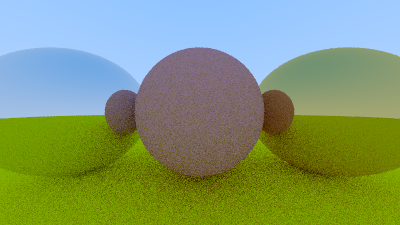

In [42]:
material_ground = Lambertian(Color(0.8, 0.8, 0.0))
material_center = Lambertian(Color(0.7, 0.3, 0.3))
material_left   = Metal(Color(0.8, 0.8, 0.8))
material_right  = Metal(Color(0.8, 0.6, 0.2))

world = [
    Sphere(Point3( 0.0, -100.5, -1.0), 100.0, material_ground),
    Sphere(Point3( 0.0,    0.0, -1.0),   0.5, material_center),
    Sphere(Point3(-1.0,    0.0, -1.0),   0.5, material_left),
    Sphere(Point3( 1.0,    0.0, -1.0),   0.5, material_right),
]


display(render(width, height))


### 9.6 Fuzzy Reflection


Elapsed time: 2.232 s


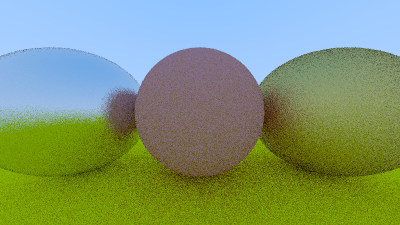

In [43]:
class Metal(Material):

    def __init__(self, albedo: Color, f):
        self.albedo = albedo
        self.fuzz = f if f < 1 else 1
        
    def scatter(self, r_in: Ray, rec: HitRecord) -> ScatterResult:

        reflected = reflect(unit_vector(r_in.direction), rec.normal)
        scattered = Ray(rec.p, reflected + random_in_unit_sphere(len(r_in))*self.fuzz)

        return ScatterResult(attenuation = self.albedo,
                             rays = scattered,
                             is_scattered = dot(scattered.direction, rec.normal) > 0)    

material_left   = Metal(Color(0.8, 0.8, 0.8), 0.3)
material_right  = Metal(Color(0.8, 0.6, 0.2), 1.0)

world = [
    Sphere(Point3( 0.0, -100.5, -1.0), 100.0, material_ground),
    Sphere(Point3( 0.0,    0.0, -1.0),   0.5, material_center),
    Sphere(Point3(-1.0,    0.0, -1.0),   0.5, material_left),
    Sphere(Point3( 1.0,    0.0, -1.0),   0.5, material_right),
]

display(render(width, height))


## 10. Dielectrics
Here we calculate both reflection and refraction for all rays. It's inefficient but easier to write, and profiling shows that we are spending little time in this function anyway.

Elapsed time: 2.878 s


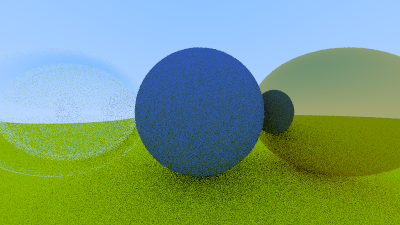

In [44]:

def refract(uv, n, etai_over_etat):
    
    cos_theta = dot(-uv, n)
    r_out_perp = (uv + n*cos_theta) * etai_over_etat
    r_out_parallel = n * (-np.sqrt(np.abs(1.0 - length_squared(r_out_perp))))
    return r_out_perp + r_out_parallel

def schlick(cosine, ref_idx):
    r0 = (1 - ref_idx) / (1 + ref_idx)
    r0 = r0 * r0
    return r0 + (1 - r0) * (1 - cosine)**5


class Dielectric(Material):
    
    def __init__(self, ref_idx):
        self.ref_idx = ref_idx

    def scatter(self, r_in: Ray, rec: HitRecord) -> ScatterResult:
        
        etai_over_etat = np.where(rec.front_face, 1.0 / self.ref_idx, self.ref_idx)
        
        unit_direction = unit_vector(r_in.direction)
        
        ## Reflection/refraction choice: calculate both and choose later
        cos_theta = np.fmin(dot(-unit_direction, rec.normal), 1.0)
        sin_theta = np.sqrt(1.0 - cos_theta*cos_theta)
        reflected = reflect(unit_direction, rec.normal)
        refracted = refract(unit_direction, rec.normal, etai_over_etat)

        reflected_rays = Ray(rec.p, reflected)
        refracted_rays = Ray(rec.p, refracted)

        reflect_prob = schlick(cos_theta, etai_over_etat)
        random_floats = my_random(0.0, 1.0, len(reflect_prob))

        must_reflect = (etai_over_etat * sin_theta > 1.0)
        again_reflect = (random_floats < reflect_prob)

        all_reflect = np.where(np.logical_or(must_reflect, again_reflect))
        
        refracted_rays[all_reflect] = reflected_rays[all_reflect]
        
        return ScatterResult(attenuation = Color(1.0, 1.0, 1.0),
                             rays = refracted_rays,
                             is_scattered = np.full(len(r_in), True, dtype=np.bool))


material_ground = Lambertian(Color(0.8, 0.8, 0.0))
material_center = Lambertian(Color(0.1, 0.2, 0.5));
material_left   = Dielectric(1.5)
material_right  = Metal(Color(0.8, 0.6, 0.2), 0.0)

world = [
    Sphere(Point3( 0.0, -100.5, -1.0), 100.0, material_ground),
    Sphere(Point3( 0.0,    0.0, -1.0),   0.5, material_center),
    Sphere(Point3(-1.0,    0.0, -1.0),   0.5, material_left),
    Sphere(Point3(-1.0,    0.0, -1.0),  -0.4, material_left),
    Sphere(Point3( 1.0,    0.0, -1.0),   0.5, material_right),
]

display(render(width, height))


## 11. Positionable Camera



Elapsed time: 0.927 s


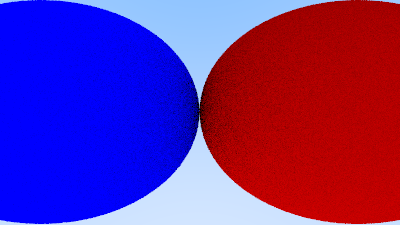

In [45]:

class Camera:

    def __init__(self, vfov,           # vertical field-of-view in degrees
                       aspect_ratio):

        theta = np.deg2rad(vfov)
        h = np.tan(theta/2)
        viewport_height = 2.0 * h;
        viewport_width = aspect_ratio * viewport_height;
        focal_length = 1.0;

        self.origin = Point3(0, 0, 0);
        self.horizontal = Vec3(viewport_width, 0.0, 0.0);
        self.vertical = Vec3(0.0, -viewport_height, 0.0);
        self.lower_left_corner = (self.origin
                                    - self.horizontal/2
                                    - self.vertical/2
                                    - Vec3(0, 0, focal_length))

    def get_ray(self, u, v):
        all_origins = origin.tile((u.size,))
        return Ray(all_origins, self.lower_left_corner
                                + self.horizontal * u
                                + self.vertical * v
                                - all_origins)

R = np.cos(np.pi/4);

material_left   = Lambertian(Color(0, 0, 1))
material_right  = Lambertian(Color(1, 0, 0))

world = [
    Sphere(Point3(-R, 0, -1), R, material_left),
    Sphere(Point3( R, 0, -1), R, material_right),
]


def get_camera():
    return Camera(90.0, aspect_ratio)


display(render(width, height))


Elapsed time: 3.012 s


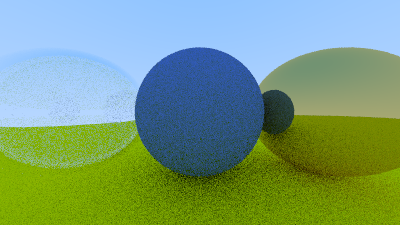

In [46]:
class Camera:

    def __init__(self, lookfrom,
                       lookat,
                       vup,
                       vfov,           # vertical field-of-view in degrees
                       aspect_ratio):

        theta = np.deg2rad(vfov)
        h = np.tan(theta/2)
        viewport_height = 2.0 * h;
        viewport_width = aspect_ratio * viewport_height;

        w = unit_vector(lookfrom - lookat)
        u = cross(vup, w)
        v = -cross(w, u)           # Minus here, to have things looking upright

        self.origin = lookfrom
        self.horizontal = u * viewport_width
        self.vertical = v * viewport_height
        self.lower_left_corner = self.origin - self.horizontal/2 - self.vertical/2 - w

    def get_ray(self, s, t):
        all_origins = self.origin.tile((s.size,))
        return Ray(all_origins, self.lower_left_corner
                                + self.horizontal * s
                                + self.vertical * t
                                - all_origins)



def get_camera():
    return Camera(lookfrom = Point3(0,0,0),
                  lookat   = Point3(0,0,-1),
                  vup      = Vec3(0,1,0),
                  vfov     = 90,
                  aspect_ratio = aspect_ratio)

material_ground = Lambertian(Color(0.8, 0.8, 0.0))
material_center = Lambertian(Color(0.1, 0.2, 0.5));
material_left   = Dielectric(1.5)
material_right  = Metal(Color(0.8, 0.6, 0.2), 0.0)

world = [
    Sphere(Point3( 0.0, -100.5, -1.0), 100.0, material_ground),
    Sphere(Point3( 0.0,    0.0, -1.0),   0.5, material_center),
    Sphere(Point3(-1.0,    0.0, -1.0),   0.5, material_left),
    Sphere(Point3(-1.0,    0.0, -1.0),  -0.45, material_left),
    Sphere(Point3( 1.0,    0.0, -1.0),   0.5, material_right),
]

display(render(width, height))


Elapsed time: 1.680 s


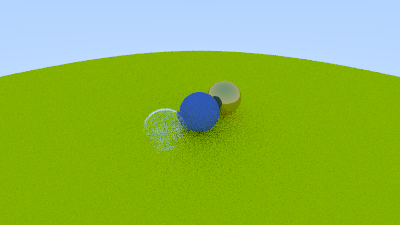

In [47]:
def get_camera():
    return Camera(lookfrom = Point3(-2,2,1),
                  lookat   = Point3(0,0,-1),
                  vup      = Vec3(0,1,0),
                  vfov      = 90,
                  aspect_ratio = aspect_ratio)

display(render(width, height))


Elapsed time: 2.931 s


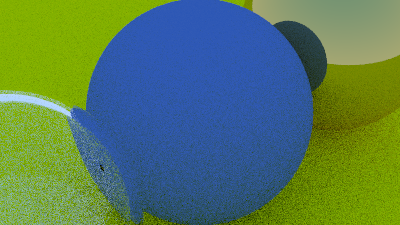

In [48]:

def get_camera():
    return Camera(lookfrom = Point3(-2,2,1),
                  lookat   = Point3(0,0,-1),
                  vup      = Vec3(0,1,0),
                  vfov      = 20,
                  aspect_ratio = aspect_ratio)

display(render(width, height))

## 12. Defocus Blur

Elapsed time: 2.661 s


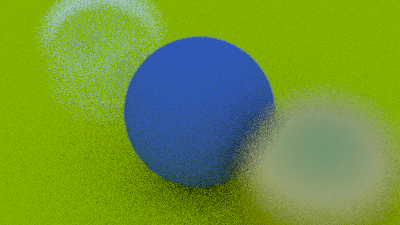

In [49]:
def random_in_unit_disk(n):
    ''''Generate random Vec3 arrays in batches and keep the ones inside the unit disk'''

    values = Vec3.zeros(0)

    while len(values) < n:
        random_values = Vec3(my_random(-1.0, 1.0, n), my_random(-1.0, 1.0, n), np.zeros(n))
        good_ones = length_squared(random_values) < 1
        values.append(random_values[good_ones])
    
    return values[:n]


class Camera:

    def __init__(self, lookfrom: Vec3,
                       lookat: Vec3,
                       vup: Vec3,
                       vfov: float,           # vertical field-of-view in degrees
                       aspect_ratio: float,
                       aperture: float,
                       focus_dist: float):

        theta = np.deg2rad(vfov)
        h = np.tan(theta/2)
        viewport_height = 2.0 * h;
        viewport_width = aspect_ratio * viewport_height;

        w = unit_vector(lookfrom - lookat)
        u = cross(vup, w)
        v = -cross(w, u)           # Minus here, to have things looking upright

        self.origin = lookfrom
        self.horizontal = u * viewport_width * focus_dist
        self.vertical = v * viewport_height * focus_dist
        self.lower_left_corner = self.origin - self.horizontal/2 - self.vertical/2 - w*focus_dist
        self.lens_radius = aperture / 2
        self.u = u
        self.v = v

    def get_ray(self, s, t):
        all_origins = self.origin.tile((s.size,))
        rd = random_in_unit_disk(s.size) * self.lens_radius
        offset = self.u * rd.x + self.v * rd.y

        return Ray(all_origins + offset, self.lower_left_corner
                                         + self.horizontal * s
                                         + self.vertical * t
                                         - all_origins - offset)
    
def get_camera():
    lookfrom = Point3(3,3,2)
    lookat = Point3(0,0,-1)
    
    return Camera(lookfrom = lookfrom,
                  lookat   = lookat,
                  vup      = Vec3(0,1,0),
                  vfov     = 20,
                  aspect_ratio = 16/9,
                  aperture = 2.0,
                  focus_dist = length(lookfrom-lookat))

display(render(width, height))

## 13. Final render
This cell is set to "Markdown" instead of "Code", because it takes several minutes to run and it would stop our notebook.

In [ ]:

def random_double(low=0.0, high=1.0):
    return np.random.uniform(low, high, 1).astype(np.float32)

def vec3_random(low=0.0, high=1.0):
    r = my_random(low, high, size=3)
    return Vec3(r[0], r[1], r[2])


ground_material = Lambertian(Color(0.5, 0.5, 0.5))

world = []
world.append(Sphere(Point3(0, -1000, 0), 1000, ground_material))

for a in range(-11, 11):
    for b in range(-11, 11):
        choose_mat = random_double()
        center = Point3(a + 0.9*random_double(), 0.2, b + 0.9*random_double())

        if length(center - Point3(4, 0.2, 0)) > 0.9:

            if choose_mat < 0.8:
                ## diffuse
                albedo = vec3_random().multiply(vec3_random())
                sphere_material = Lambertian(albedo)
                world.append(Sphere(center, 0.2, sphere_material))

            elif choose_mat < 0.95:
                ## metal
                albedo = vec3_random(0.5, 1)
                fuzz = random_double(0, 0.5)
                sphere_material = Metal(albedo, fuzz)
                world.append(Sphere(center, 0.2, sphere_material))

            else:
                ## glass
                sphere_material = Dielectric(1.5)
                world.append(Sphere(center, 0.2, sphere_material))


world.append(Sphere(Point3( 0, 1, 0), 1.0, Dielectric(1.5)))
world.append(Sphere(Point3(-4, 1, 0), 1.0, Lambertian(Color(0.4, 0.2, 0.1))))
world.append(Sphere(Point3( 4, 1, 0), 1.0, Metal(Color(0.7, 0.6, 0.5), 0.0)))

image_width = 1000
aspect_ratio = 3/2
image_height = int(image_width / aspect_ratio)
samples_per_pixel = 3
max_depth = 50

def get_camera():
    lookfrom = Point3(13,2,3)
    lookat = Point3(0,0,0)
    
    return Camera(lookfrom = lookfrom,
                  lookat   = lookat,
                  vup      = Vec3(0,1,0),
                  vfov     = 20,
                  aspect_ratio = aspect_ratio,
                  aperture     = 0.1,
                  focus_dist   = 10.0)

display(render(image_width, image_height))

## Optimizations
Our render works, but is very slow. We'll try to make it faster.



### length_squared()
One of the heaviest used functions is length_squared(). We'll cache the most common usage, before calling update_hit_record(), using the property decorator. This optimization alone makes the overall render about 10% faster.

Elapsed time: 0.897 s


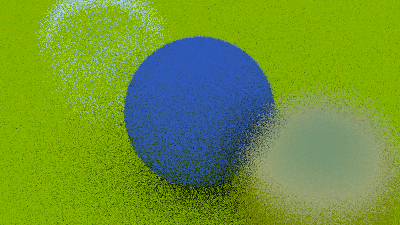

In [53]:
class Ray:
    def __init__(self, origin, direction):
        self.origin = origin
        self.direction = direction
        self._direction_length_squared = None

    def at(self, t):
        return self.origin + self.direction*t
    
    def __getitem__(self, idx):
        return Ray(self.origin[idx], self.direction[idx])

    def __setitem__(self, idx, other):
        self.origin[idx] = other.origin
        self.direction[idx] = other.direction
        self._direction_length_squared = None

    def __len__(self):
        return self.origin.x.size
    
    def direction_length_squared(self):
        if self._direction_length_squared is None:
            self._direction_length_squared = length_squared(self.direction)
        return self._direction_length_squared


class Sphere(Hittable):
    '''A hittable sphere that knows how to update the hit record'''

    def __init__(self, center, radius, material):
        self.center = center
        self.radius = radius
        self.material = material

    def update_hit_record(self, rays, t_min, t_max, hit_record):

        oc = rays.origin - self.center
        a = rays.direction_length_squared()                    # Changed here
        half_b = dot(oc, rays.direction)
        c = length_squared(oc) - self.radius*self.radius
        discriminant = half_b*half_b - a*c
        
        root = np.sqrt(discriminant)
        t1 = (-half_b - root) / a
        t2 = (-half_b + root) / a
        hit1 = np.logical_and(t1 < t_max, t1 > t_min)
        hit2 = np.logical_and(t2 < t_max, t2 > t_min)
        
        # Combine the two hits, precedence to t1 (closest)
        t = np.where(hit2, t2, np.inf)
        t = np.where(hit1, t1, t)       
        
        # Detect where in the rays list we are the closest hit
        closest = np.where(t < hit_record.t)
        
        # Early exit if nothing hit
        if len(closest[0]) == 0:
            return
        
        # Calculate normal
        hit_rays = rays[closest]
        
        p = hit_rays.at(t[closest])
        outward_normal = (p - self.center) / self.radius 
        front_face = dot(hit_rays.direction, outward_normal) < 0 
        normal = Vec3.where(front_face, outward_normal, -outward_normal)
        
        # Update hit record
        hit_record.p[closest] = p
        hit_record.normal[closest] = normal
        hit_record.t[closest] = t[closest]
        hit_record.front_face[closest] = front_face
        hit_record.material_id[closest] = id(self.material)

image_width = 400
aspect_ratio = 16/9
image_height = int(image_width / aspect_ratio)
samples_per_pixel = 3
max_depth = 50

def get_camera():
    lookfrom = Point3(3,3,2)
    lookat = Point3(0,0,-1)
    
    return Camera(lookfrom = lookfrom,
                  lookat   = lookat,
                  vup      = Vec3(0,1,0),
                  vfov     = 20,
                  aspect_ratio = 16/9,
                  aperture = 2.0,
                  focus_dist = length(lookfrom-lookat))

display(render(image_width, image_height))


### np.array()
The np.array() calls in the Vec3 initializers are almost always useless, because most of the time the arguments are already arrays. Removing these calls will gain another 10%:

Elapsed time: 0.760 s


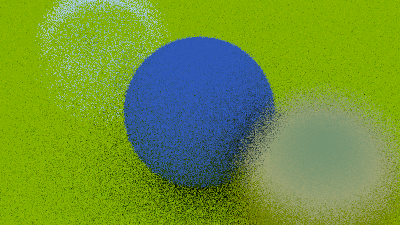

In [54]:
class Vec3:
    def __init__(self, x=0.0, y=0.0, z=0.0):
        self.x = x if type(x) == np.ndarray else np.array(x, dtype=np.float32)
        self.y = y if type(y) == np.ndarray else np.array(y, dtype=np.float32)
        self.z = z if type(z) == np.ndarray else np.array(z, dtype=np.float32)

    @staticmethod
    def empty(size):
        x = np.empty(size, dtype=np.float32)
        y = np.empty(size, dtype=np.float32)
        z = np.empty(size, dtype=np.float32)
        return Vec3(x,y,z)

    @staticmethod
    def zeros(size):
        x = np.zeros(size, dtype=np.float32)
        y = np.zeros(size, dtype=np.float32)
        z = np.zeros(size, dtype=np.float32)
        return Vec3(x,y,z)

    @staticmethod
    def ones(size):
        x = np.ones(size, dtype=np.float32)
        y = np.ones(size, dtype=np.float32)
        z = np.ones(size, dtype=np.float32)
        return Vec3(x,y,z)
    
    @staticmethod
    def where(condition, v1, v2):
        x = np.where(condition, v1.x, v2.x)
        y = np.where(condition, v1.y, v2.y)
        z = np.where(condition, v1.z, v2.z)
        return Vec3(x,y,z)
    
    def clip(self, vmin, vmax):
        x = np.clip(self.x, vmin, vmax)
        y = np.clip(self.y, vmin, vmax)
        z = np.clip(self.z, vmin, vmax)
        return Vec3(x,y,z)

    def fill(self, value):
        self.x.fill(value)
        self.y.fill(value)
        self.z.fill(value)
    
    def __str__(self):
        return 'vec3: x:%s y:%s z:%s' % (str(self.x), str(self.y), str(self.z))
    
    def __len__(self):
        return self.x.size

    def __add__(self, other):
        return Vec3(self.x + other.x, self.y + other.y, self.z + other.z)

    def __sub__(self, other):
        return Vec3(self.x - other.x, self.y - other.y, self.z - other.z)

    def __neg__(self):
        return Vec3(-self.x, -self.y, -self.z)

    def __mul__(self, scalar):
        return Vec3(self.x*scalar, self.y*scalar, self.z*scalar)

    def multiply(self, other):
        return Vec3(self.x * other.x, self.y * other.y, self.z * other.z)

    def __truediv__(self, scalar):
        return Vec3(self.x/scalar, self.y/scalar, self.z/scalar)
    
    def tile(self, shape):
        '''Replicate np.tile on each component'''
        return Vec3(np.tile(self.x, shape), np.tile(self.y, shape), np.tile(self.z, shape))

    def __getitem__(self, idx):
        '''Extract a vector subset'''
        return Vec3(self.x[idx], self.y[idx], self.z[idx])
    
    def __setitem__(self, idx, other):
        '''Set a vector subset from another vector'''
        self.x[idx] = other.x
        self.y[idx] = other.y
        self.z[idx] = other.z

    def join(self):
        '''Join the three components into a single 3xN array'''
        return np.vstack((self.x, self.y, self.z))
    
    def append(self, other):
        '''Append another vector to this one.
        Use concatenate() because cupy has no append function.
        '''
        self.x = np.concatenate((self.x, other.x))
        self.y = np.concatenate((self.y, other.y))
        self.z = np.concatenate((self.z, other.z))
        
display(render(image_width, image_height))


### Smarter hit record
When we have lots of objects in our world (like it the final render, almost 500 spheres), the hit record fields are going to be overwritten many times as closer and closer hits are found. We can split *update_hit_record()* in two parts, one to look for the closest sphere, and the other to calculate the normals.

We will also take advantage of the fact that our t_max is always infinite, so there is no real need to check against it, and optimize the *t* comparison.



Elapsed time: 0.552 s


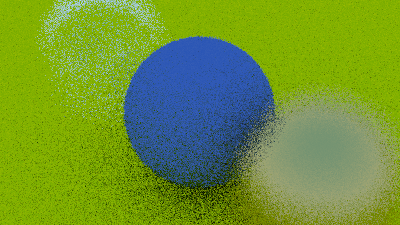

In [56]:
class HitRecord:
    def __init__(self, n, empty=False):
        self.p           = empty or Vec3.empty(n)
        self.normal      = empty or Vec3.empty(n)
        self.front_face  = empty or np.empty(n, dtype=np.bool)
        self.t           = empty or np.full(n, np.inf, dtype=np.float32)
        self.center      = empty or Vec3.empty(n)
        self.radius      = empty or np.empty(n, dtype=np.float32)
        self.index       = empty or np.arange(n, dtype=np.int32)
        self.material_id = empty or np.zeros(n, dtype=np.int64)

    def __getitem__(self, idx):
        other = HitRecord(len(idx), empty=True)
        other.p           = self.p[idx]
        other.normal      = self.normal[idx]
        other.front_face = self.front_face[idx]
        other.t           = self.t[idx]
        other.center      = self.center[idx]
        other.radius      = self.radius[idx]
        other.index       = self.index[idx]
        other.material_id = self.material_id[idx]
        return other

    
class Sphere(Hittable):
    '''A hittable sphere that knows how to update the hit record'''

    def __init__(self, center, radius, material):
        self.center = center
        self.radius = radius
        self.material = material 

    def update_hit_record(self, rays, t_min, t_max, hit_record):
        
        oc = rays.origin - self.center
        a = rays.direction_length_squared()
        half_b = dot(oc, rays.direction)
        c = length_squared(oc) - self.radius*self.radius
        discriminant = half_b*half_b - a*c
        
        hits = np.where(discriminant >= 0)[0]

        # Early exit if our rays did not hit the sphere at all
        if len(hits) == 0:
            return

        # Only calculate roots on those rays that have hit
        half_b = half_b[hits]
        a = a[hits]
        
        root = np.sqrt(discriminant[hits])
        t1 = (-half_b - root) / a
        t2 = (-half_b + root) / a
        
        # Update hit record where we are the closest
        t = np.where(t1 > t_min, t1, t2)
        closest = np.where((t < hit_record.t[hits]) & (t > t_min))
        
        idx = hits[closest]
        hit_record.t[idx] = t[closest]
        hit_record.center[idx] = self.center
        hit_record.radius[idx] = self.radius
        hit_record.material_id[idx] = id(self.material)


def calculate_normals(rays, hit_record):

    p = rays.at(hit_record.t)
    outward_normal = (p - hit_record.center) / hit_record.radius 
    front_face = dot(rays.direction, outward_normal) < 0 
    normal = Vec3.where(front_face, outward_normal, -outward_normal)
    
    return p, normal, front_face


def ray_color(rays):
    '''Iterative version with materials'''

    intensity = Vec3.ones(len(rays))
    all_rays = rays
    hit_record = HitRecord(len(rays))

    materials = set([x.material for x in world])

    for d in range(max_depth):

        # Initialize all distances to infinite and propagate all rays
        hit_record.t.fill(np.inf)
        hit_record.material_id.fill(0)
        
        for hittable in world:
            hittable.update_hit_record(rays, 0.001, np.inf, hit_record)         
        
        # Calculate all hits normal and build a hit record for the scattering
        hits = np.where(hit_record.t != np.inf)[0]
        p, normal, front_face = calculate_normals(rays[hits], hit_record[hits])
        
        material_rays = rays[hits]
        material_hit_record = hit_record[hits]
        material_hit_record.p = p
        material_hit_record.normal = normal
        material_hit_record.front_face = front_face
        
        for material in materials:

            material_hits = np.where(material_hit_record.material_id == id(material))[0]
            if len(material_hits) == 0:
                continue

            # Narrow down to this material and scatter
            my_rays = material_rays[material_hits]
            my_rec = material_hit_record[material_hits]
            result = material.scatter(my_rays, my_rec)         
            
            # All rays have done something
            all_rays[my_rec.index] = result.rays
            
            # Attenuation
            this_intensity = result.attenuation.multiply(intensity[my_rec.index])
            this_intensity[np.where(~result.is_scattered)] = Vec3(0,0,0)
            intensity[my_rec.index] = this_intensity

            # Those that have been scattered stop here
            not_scattered_material_idx = hits[material_hits[~result.is_scattered]]
            hit_record.t[not_scattered_material_idx] = np.inf
            
        # Iterate with those rays that have been scattered by something
        scattered_rays = np.where(hit_record.t != np.inf)[0]

        hit_record = hit_record[scattered_rays]
        rays = all_rays[hit_record.index]

        if len(rays) == 0:
            break
            
    unit_direction = unit_vector(all_rays.direction)
    t = 0.5 * unit_direction.y + 1.0
    img = (Color(1.0, 1.0, 1.0) * (1 - t) + Color(0.5, 0.7, 1.0) * t).multiply(intensity)

    return img

world = [
    Sphere(Point3( 0.0, -100.5, -1.0), 100.0, material_ground),
    Sphere(Point3( 0.0,    0.0, -1.0),   0.5, material_center),
    Sphere(Point3(-1.0,    0.0, -1.0),   0.5, material_left),
    Sphere(Point3(-1.0,    0.0, -1.0),  -0.45, material_left),
    Sphere(Point3( 1.0,    0.0, -1.0),   0.5, material_right),
]

display(render(image_width, image_height))


## Multiprocessing
First we split the rendering function for a single sample into its own function

0
1
2
Elapsed time: 0.554 s


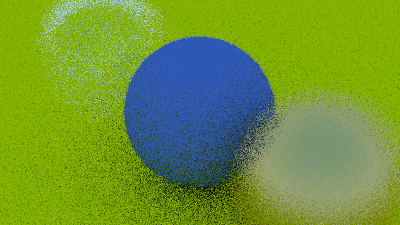

In [59]:


def img_for_sample(s, cam, u, v, width, height):
    
    uu = u + my_random(0.0, 1.0, u.size) / (width - 1)
    vv = v + my_random(0.0, 1.0, v.size) / (height - 1)

    rays = cam.get_ray(uu,vv)

    return ray_color(rays)    
    
    
def render_image(width, height):
    with Timer():
        ii, jj = np.mgrid[:float(height), :float(width)]

        u = (jj/(width-1)).flatten().astype(np.float32)
        v = (ii/(height-1)).flatten().astype(np.float32)

        cam = get_camera()

        img = Vec3.zeros(width * height)
        for s in range(samples_per_pixel):
            
            print(s)
            img += img_for_sample(s, cam, u, v, width, height)
            
        img *= 1.0 / samples_per_pixel
        img.x = np.sqrt(img.x)
        img.y = np.sqrt(img.y)
        img.z = np.sqrt(img.z)
        return img.clip(0.0, 0.999)


display(render(width, height))

Then we call it from a multiprocessing.Pool. It does not work on the notebook, because Pickle gets confuse by our multiple class redefinitions in the above cells. Therefore the following cell is not marked as code.



import multiprocessing as mp
from functools import partial, reduce

def render_image(width, height):
    with Timer():
        ii, jj = np.mgrid[:float(height), :float(width)]

        u = (jj/(width-1)).flatten().astype(np.float32)
        v = (ii/(height-1)).flatten().astype(np.float32)

        cam = get_camera()1

        img = Vec3.zeros(width * height)
        myfunc = partial(img_for_sample, cam=cam, u=u, v=v, width=width, height=height)
        
        with mp.Pool() as p:
            samples = p.map(myfunc, range(samples_per_pixel))
           
        img = sum(samples)
        img *= 1.0 / samples_per_pixel
        img.x = np.sqrt(img.x)
        img.y = np.sqrt(img.y)
        img.z = np.sqrt(img.z)
        return img.clip(0.0, 0.999)

display(render(width, height))